# Drifters module - demo

`pynsitu.drifters` implements methods useful to the cleaning and processing of drifter trajectories.

Drifter data is assumed to be contained within a pandas dataframe with with a least the following columns: time, longitude, latitude. 
A column may also described the drifter id.


In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pin

---

## generate synthetic drifter trajectories


In [2]:
def generate_one_trajectory(
    u_mean=-0.1, v_mean=0, u_wave=0.1, noise=0.05, dr_id="dr0", end="2018-02-01"
):

    freq = "1H"

    time_unit = pd.Timedelta("1s")
    dt = pd.Timedelta(freq) / time_unit
    time = pd.date_range(start="2018-01-01", end=end, freq=freq)
    _time = (time - time[0]) / time_unit

    lon0, lat0 = -20, 30
    scale_lat = 111e3
    scale_lon = scale_lat * np.cos(lat0 * pin.deg2rad)
    T = pd.Timedelta("1D") / time_unit

    u = (
        u_mean
        + u_wave * np.cos(2 * np.pi * _time / T)
        + np.random.randn(time.size) * noise
    )
    v = (
        v_mean
        + u_wave * np.sin(2 * np.pi * _time / T)
        + np.random.randn(time.size) * noise
    )

    lon = lon0 + np.cumsum(u) * dt / scale_lon
    lat = lat0 + np.cumsum(v) * dt / scale_lat
    # lon = u
    # lat = v

    df = pd.DataFrame(dict(lon=lon, lat=lat, time=time, u=u, v=v))
    df["id"] = dr_id
    df = df.set_index("time")

    return df

In [3]:
# actually generate one time series
df = generate_one_trajectory()
df.head()

,lon,lat,u,v,id
time,,,,,
2018-01-01 00:00:00,-20.000788,29.999491,-0.021034,-0.015686,dr0
2018-01-01 01:00:00,-20.001118,29.998477,-0.008826,-0.031258,dr0
2018-01-01 02:00:00,-19.997529,29.999040,0.095854,0.017331,dr0
2018-01-01 03:00:00,-20.000823,30.002137,-0.087982,0.095500,dr0
2018-01-01 04:00:00,-20.004857,30.005824,-0.107715,0.113700,dr0


---

## basic plots to inspect data

May be useful to clean up drifter time series

In [4]:
df.geo.plot_bokeh()

Loading BokehJS ...

In [5]:
phv, coords = df.geo.plot_on_map()
phv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (time)

### compute velocities

Multiple methods are employed to compute velocities, see `compute_velocities` doc and code.
Some involve projecting data which results in local cartesian coordinates `x` and `y`.

In [6]:
df.geo.compute_velocities(inplace=True)
df.head()

,lon,lat,u,v,id,x,y,velocity_east,velocity_north,velocity
time,,,,,,,,,,
2018-01-01 00:00:00,-20.000788,29.999491,-0.021034,-0.015686,dr0,133960.361743,1031.830412,-0.113929,-0.079742,0.139063
2018-01-01 01:00:00,-20.001118,29.998477,-0.008826,-0.031258,dr0,133929.833767,919.064918,0.043676,-0.006953,0.044226
2018-01-01 02:00:00,-19.997529,29.999040,0.095854,0.017331,dr0,134275.412685,985.574663,0.003952,0.056342,0.056480
2018-01-01 03:00:00,-20.000823,30.002137,-0.087982,0.095500,dr0,133953.359341,1325.061218,-0.098208,0.104462,0.143378
2018-01-01 04:00:00,-20.004857,30.005824,-0.107715,0.113700,dr0,133559.241127,1729.127419,-0.115983,0.087820,0.145480


In [7]:
df.geo.plot_bokeh(velocity=True)

Loading BokehJS ...

In [8]:
phv, coords = df.geo.plot_on_map(s=10, c="velocity", clim=(0, 0.3), cmap="magma")
phv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (velocity,time)

### compare different methods to compute velocities

In [9]:
df_sp = df.geo.compute_velocities(distance="spectral", inplace=False)
df_xy = df.geo.compute_velocities(distance="xy", inplace=False)

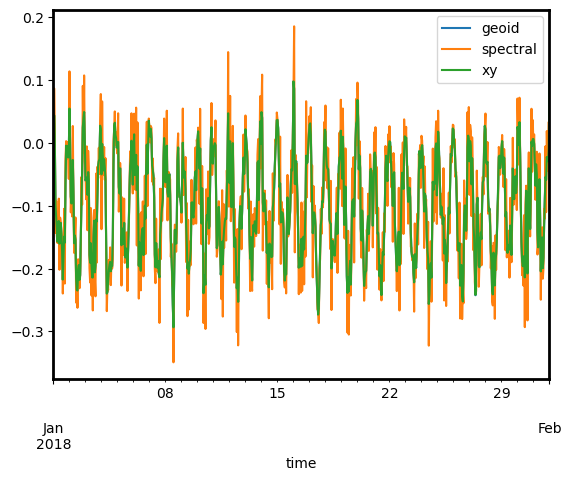

In [10]:
df["velocity_east"].plot(label="geoid")
df_sp["velocity_east"].plot(label="spectral")
df_xy["velocity_east"].plot(label="xy")
plt.legend()

In [11]:
kwargs = dict(include=["velocity_east"], nperseg=24 * 5, detrend=False)
E = df.ts.spectrum(**kwargs)
E_sp = df_sp.ts.spectrum(**kwargs)
E_xy = df_xy.ts.spectrum(**kwargs)

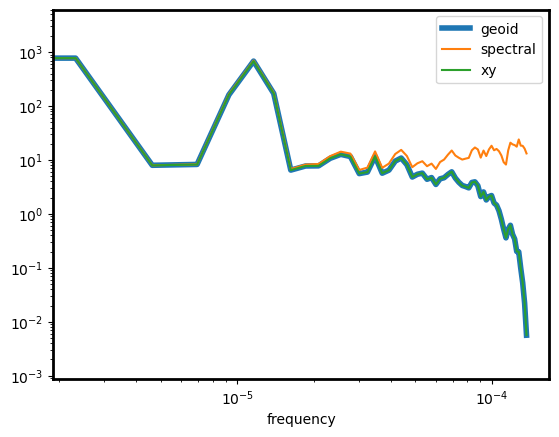

In [12]:
# spectrum comparison
ax = E["velocity_east"].rename("geoid").plot(lw=4)
E_sp["velocity_east"].rename("spectral").plot(ax=ax)
E_xy["velocity_east"].rename("xy").plot(ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

---

## concatenate multiple trajectories and manipulate

In [13]:
ids = [0, 1, 2]
u_wave = [0, 0.1, 0.2]
dfm = (
    pd.concat(
        [
            generate_one_trajectory(
                u_mean=-0.1, v_mean=0, u_wave=uw, noise=0.05, dr_id=f"dr{i}"
            )
            for i, uw in zip(ids, u_wave)
        ]
    )
    .reset_index()
    .set_index("id")
)

# get all drifter ids
ids = list(dfm.index.unique())

dfm.head()

,time,lon,lat,u,v
id,,,,,
dr0,2018-01-01 00:00:00,-20.001938,30.001574,-0.051755,0.048540
dr0,2018-01-01 01:00:00,-20.003740,29.999217,-0.048114,-0.072674
dr0,2018-01-01 02:00:00,-20.007893,29.998033,-0.110882,-0.036504
dr0,2018-01-01 03:00:00,-20.014289,29.997121,-0.170800,-0.028130
dr0,2018-01-01 04:00:00,-20.018838,29.996461,-0.121469,-0.020351


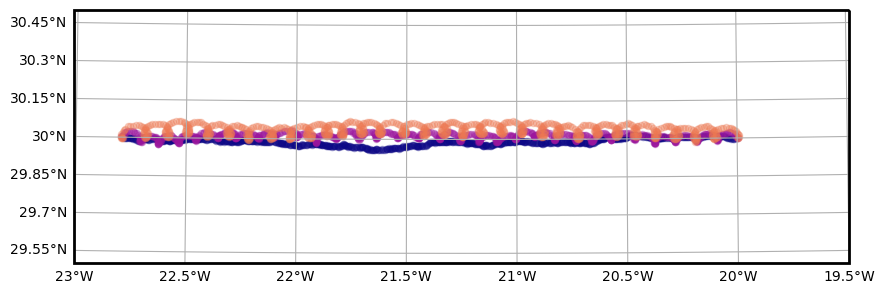

In [14]:
fig, ax, _ = pin.maps.plot_map(extent=[-23.0, -19.5, 29.5, 30.5])

colors = pin.get_cmap_colors(len(ids))

for i, c in zip(ids, colors):
    dfm.loc[i].plot.scatter(
        ax=ax, x="lon", y="lat", c=c, alpha=0.3, transform=pin.maps.crs
    )

Compute velocities and averaged energy per drifter

In [15]:
dfm_vel = (
    dfm.groupby("id")
    .apply(lambda df: df.set_index("time").geo.compute_velocities().reset_index())
    .droplevel(1)
)

<Axes: xlabel='id'>

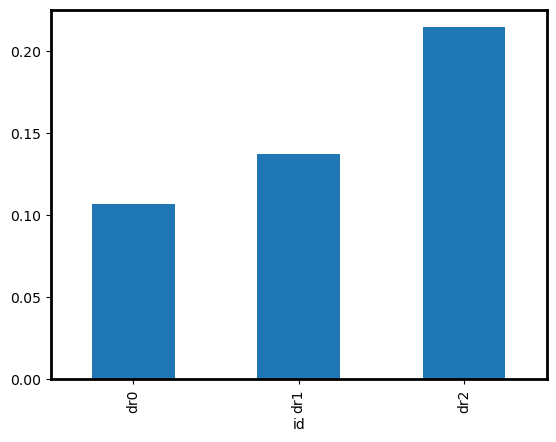

In [16]:
dfm_vel.groupby("id")["velocity"].mean().plot.bar()

---

## compute temporal window averaged diagnostics (spectra, autocorrelations)

When manipulating drifter time series one may need to divide the timeseries into chunks ("windows") and performs diagnostics on each chunk separately before combining results.
This may typically be the case for spectral or autocorrelation diagnostics.

In [17]:
df = generate_one_trajectory(dr_id="dr0", end="2018-04-01")

In [18]:
def compute_periodogram(df, **kwargs):
    df["U"] = df["u"] + 1j * df["v"]
    return df.ts.spectrum(method="periodogram", unit="1D", include=["U"], **kwargs)["U"]


P = pin.drifters.time_window_processing(
    df,
    compute_periodogram,
    "10D",
    geo=True,
    detrend="linear",
)
P = P.reset_index()

In [19]:
# assembles as an xarray dataset
coords = ["time", "lon", "lat", "id"]
P_stacked = (
    P.drop(columns=coords)
    .stack()
    .to_xarray()
    .rename(level_0="index", level_1="frequency")
    .rename("uv")
)
P_stacked["frequency"] = P_stacked["frequency"].astype(float)
P_xr = xr.merge(
    [
        P[coords].to_xarray(),
        P_stacked,
    ]
)
P_xr

<xarray.Dataset>
Dimensions:    (index: 16, frequency: 2161)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * frequency  (frequency) float64 -11.99 -11.98 -11.97 ... 11.97 11.98 11.99
Data variables:
    time       (index) datetime64[ns] 2018-01-06 2018-01-11 ... 2018-03-22
    lon        (index) float64 -20.5 -20.95 -21.39 ... -26.25 -26.7 -27.13
    lat        (index) float64 29.99 29.97 29.96 29.94 ... 29.86 29.86 29.87
    id         (index) object 'dr0' 'dr0' 'dr0' 'dr0' ... 'dr0' 'dr0' 'dr0'
    uv         (index, frequency) float64 0.0002499 5.11e-05 ... 0.0003054

One performs next an averaged conditionned on `time`, `lon`, `lat`, and/or `id`.

This averaging can be performed from the pandas Dataframe `P` or the xarrat Dataset `P_xr`.

Here compute a global average from the xarray Dataset:

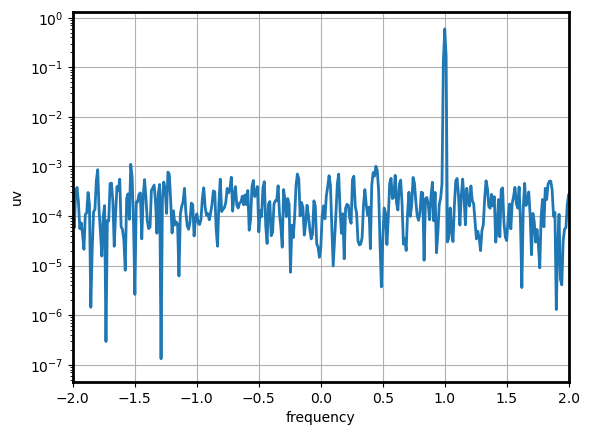

In [21]:
fig, ax = plt.subplots(1, 1)
P_xr["uv"].mean("index").plot(ax=ax, lw=2)
ax.set_yscale("log")
ax.set_xlim(-2, 2)
ax.grid()

---

## denoise/despike time series

In [ ]:
...